# Free Diving into Food Facts : Milestone 2

## Contents
* [Introduction](#introduction)
* [Dataset Overview](#datasetoverview)
    * [Available fields](#availablefields)
    * [General cleaning](#generalcleaning)
    * [Data completeness](#datacompleteness)
    * [Reliablity of the dataset](#reliabilityofthedataset)
* [Question 1: How do nutrients influence the selected nutrition scores?](#q1)
    * [Additional cleaning](#q1_additionalcleaning)
    * [Data exloration](#q1_dataexploration)
    * [Results](#q1_results)
* [Question 2: Comparing bio vs. normal products, is there a real difference in composition?](#q2)
    * [Data exloration](#q2_dataexploration)
    * [Results](#q2_results)
* [Question 3: What are the levels of interdependencies between nations based on their production and importation?](#q3)
    * [Additional cleaning](#q3_additionalcleaning)
    * [Data exloration](#q3_dataexploration)
    * [Results](#q3_results)
* [Complementary dataset](#complementarydataset)
* [Conclusion: proposed data story](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

We are going to analyze the [Open Food Facts dataset](https://world.openfoodfacts.org/). We will assert the completeness and cleanliness of the data. We start to explore the questions proposed in Milestone 1 and study their feasability. For each question, we present preliminary results and a direction for future research. 

At the end of this notebook, based on the preliminary results obtained, we formulate the concept of the data story for the final version. 

## Dataset overview <a class="anchor" id="datasetoverview"></a>

We import required packages as well as the dataset itself. The goal of this section is to analyze the structure of the dataset and prepare it for further analysis. We will assess the quality of the dataset based on its levels of completeness and how reliable the data is in general. 

In [ ]:
import pickle
import time
import sys
import os
import json
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

Let us load the dataset: 

In [ ]:
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

In [ ]:
print("We have {} rows, hence products, in the dataset.".format(food_facts_df.shape[0]))
print("We have {} columns, hence fields, in the dataset.".format(food_facts_df.shape[1]))

### Available fields <a class="anchor" id="availablefields"></a> 

The dataset description is available [here](https://static.openfoodfacts.org/data/data-fields.txt).



This dataset is provided with a text file describing the different fields. We present a brief overview of the main types of fields:

* field `code` containing the product's code. 
* field `creator` indicating who added the product to the dataset. 
* field `countries` showing where the product is selled. 
* fields that end with `_t` are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
* fields that end with `_datetime` are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
* fields that end with `_tags` are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
* fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
* fields that end with `_100g` correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
* fields that end with `_serving` correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

### General cleaning <a class="anchor" id="generalcleaning"></a> 

Each product of the dataset has a field named `code`. It should be unique to each row. This is the case in general, except for a small number of duplicates. Let's check that:

In [ ]:
print("We have {} rows in the dataset".format(food_facts_df.shape[0]))
print("We have {} different code in the dataset".format((np.unique(food_facts_df['code']).shape[0])))

In [ ]:
number_duplicates=food_facts_df['code'].duplicated()
print("We have {} duplicated code".format(number_duplicates.value_counts()[1]))

There are a few codes that are duplicated. Let's start by dropping these duplicated rows:

In [ ]:
food_facts_df.drop_duplicates(subset=['code'],inplace=True)
print("We have {} rows in the dataset after dropping the duplicates.".format(food_facts_df.shape[0]))

Great! We have now a unique code for each row. We can set the code as an index for the whole dataset.

In [ ]:
#lets fix the code as index
food_facts_df.set_index('code', inplace=True)

In [ ]:
food_facts_df.head(5)

As we can see from the 5 first rows in the dataset, the data is messy and has a huge number of NaNs. We need quite some data cleaning.

### Data completeness <a class="anchor" id="datacompleteness"></a> 

Based on the head of the dataset displayed above, the data seems to be sparse. Let us assess how sparse the data really is globally. We plot here for each field, the percentage of values that are not `NaN`. 

Let us declare some utility functions to help us:

In [ ]:
def get_field_without_nan(df:pd.DataFrame, field='origins'):
    '''
    Returns a Series of none nan values for the specified "field".
    Specifiy the length of the Series to return with "head". 
    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :return: Series, containing all none nan values. 
    '''
    return df[field].dropna()

In [ ]:
def get_fields_completeness(df:pd.DataFrame, fields:list, verbose=False):
    '''
    Create a barh plot of the levels of non nan values per field. 
    :param df: dataframe to extract info from
    :param fields: fields of the database to evaluate
    :param verbose: show progress
    :return: dict, completeness of each field
    '''
    fields_fill_percentage = {}
    total_number=len(df)
    for i,field in enumerate(fields):
        fields_fill_percentage[field] = len(get_field_without_nan(df,field))/total_number
        if verbose:
            print('Done [%d/%d]' % (i+1,len(fields)), end='\r')
    return fields_fill_percentage

In [11]:
fields_all_fill_percentage = get_fields_completeness(food_facts_df,food_facts_df.columns,verbose=False)

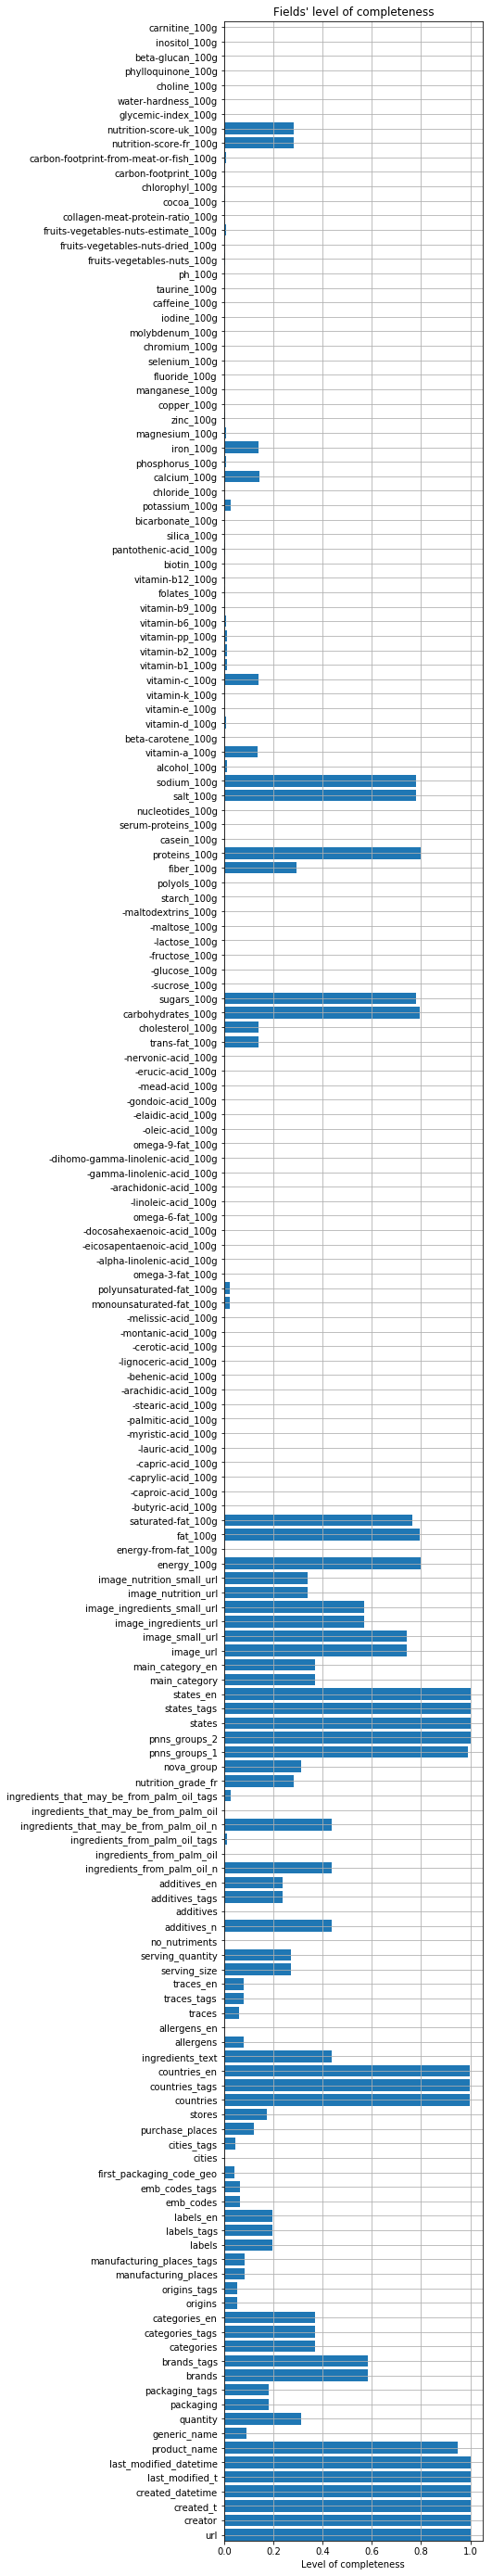

In [12]:
plt.figure(figsize=(5,50))
plt.barh(list(fields_all_fill_percentage.keys()),list(fields_all_fill_percentage.values()))
plt.title('Fields\' level of completeness')
plt.xlabel('Level of completeness')
plt.margins(y=0)
plt.grid()

The information contained in this dataset is extremely sparse. Very few fields consistently provide information about the products. This means that we need to be careful when trying to answer any question and need to make sure we actually have enough information to gain real insights on a subject. 

It means we need specific cleaning and data extraction for each question we will tackle. Performing a global cleaning would lead to great loss of information since most of the time, no information is available. 

### Reliability of the dataset <a class="anchor" id="reliabilityofthedataset"></a> 


A way of checking the reliability of a product and its information, is to verifiy who the contributor is. If the contributor is an organisation or is part of an organisation, then its contribution should be more reliable compared to the one of a single individual. 

The creators of each row of the dataset are provided in a dedicated field. Let's try to see who are the main contributors to this data before starting to analyze it.

In [13]:
# Computing the number of contributors
nb_contributors=food_facts_df['creator'].unique().shape[0]
print("We have overall {} contributors".format(nb_contributors))

We have overall 9514 contributors


Let's see how many contributions each creator has in the dataset

In [14]:
# Computing the contributions 
counts = food_facts_df['creator'].value_counts()
counts = counts.to_frame(name='counts')
counts['percentage'] = counts['counts']/food_facts_df.shape[0]

# Extracting only the top find and calculating the percentage of contribution
top_10 = round(sum(counts[0:10]['percentage']),2)*100
print("The 10 main", 'creators',"account for", top_10,"% of all contributions \n")
print(counts.head(10))

The 10 main creators account for 89.0 % of all contributions 

                            counts  percentage
kiliweb                     540476    0.525122
usda-ndb-import             169854    0.165029
openfoodfacts-contributors  116884    0.113564
date-limite-app              25144    0.024430
elcoco                       24829    0.024124
openfood-ch-import           11459    0.011133
sebleouf                     10140    0.009852
tacite                        8505    0.008263
tacinte                       5556    0.005398
waistline-app                 4467    0.004340


After googling these 10 main contributors we can easily identify them: 
* `kiliweb` represents the [YUKA app](https://yuka.io/en/) (a French app aiming at evaluating the quality of products).
* `usda` represents [United States Department of Agriculture](https://www.usda.gov/). 
* `openfoodfacts-contributors` a bench of 20 main contributors.
* `data-limite-app` food application available for ios and androids users (French app).
* `Elcoco` also a food application (spanish app).
* `openfood-ch-import` seems to be openfood contributors from Switzerland.
* `sebleouf`, `tacite` , `tacinte` and `waistline-app` are unknown contributors. 

The first 6 sources of contributions seem to be reliable since they correspond to recognized organisations in the field of food products evaluation. Furhtermore, they provided most of the data in this dataset, approximately **85%**.  

## Question 1: How do nutrients influence the selected nutrition scores? <a class="anchor" id="q1"></a> 

The majority of the dataset's fields are nutrients. We will try in this part to evaluate their impact on the nutrition score. This analysis requires an additional cleaning of the dataset to properly handle the nutrients information. 

### Additional cleaning <a class="anchor" id="q1_additionalcleaning"></a> 

First, we will see the data type of all fields: 

In [15]:
#create a copy from the original dataset
nutrition_food_fact_df=food_facts_df

In [16]:
nutrition_food_fact_df.dtypes

url                    object
creator                object
created_t               int64
created_datetime       object
last_modified_t         int64
                       ...   
choline_100g          float64
phylloquinone_100g    float64
beta-glucan_100g      float64
inositol_100g         float64
carnitine_100g        float64
Length: 174, dtype: object

We will discard all no-float fields since they cannot represent nutrients (i.e. `object`). 

In [17]:
nutrition_food_fact_df = nutrition_food_fact_df.select_dtypes(include=[np.float])

In [18]:
nutrition_food_fact_df.columns

Index(['cities', 'allergens_en', 'serving_quantity', 'no_nutriments',
       'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil', 'nova_group',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=117)

In [19]:
print('There are now {:,} columns left in our data.'.format(nutrition_food_fact_df.shape[1]))

There are now 117 columns left in our data.


In [20]:
nutrition_food_fact_df.head()

,cities,allergens_en,serving_quantity,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nova_group,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,NaN,NaN,0.0,NaN,1.0,0.0,NaN,0.0,NaN,NaN,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000000001111111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, our dataset has a huge number of NaNs. **Dropping all of them would lead to an empty dataframe**. 

#### Dealing with missing values
As a simple strategy to deal with these missing values, we will remove the features where the number of missing values exceeds a certain threshold. This will let us work with fields that contain enough data to perform some analysis. 

Let's count the number of nans for each feature: 

In [21]:
# Duplicate the selected columns
nutrition_facts_df = nutrition_food_fact_df.copy()

In [22]:
# Display the number of NaNs per field
NaNs_distribution_series = nutrition_facts_df.isnull().sum().sort_values()
NaNs_distribution_series

energy_100g                   205970
proteins_100g                 208832
fat_100g                      210710
carbohydrates_100g            210752
sugars_100g                   224824
                              ...   
-gondoic-acid_100g           1029238
-elaidic-acid_100g           1029238
-melissic-acid_100g          1029238
ingredients_from_palm_oil    1029238
cities                       1029238
Length: 117, dtype: int64

Let us visualize the distribution of NaNs in the dataset's fields:

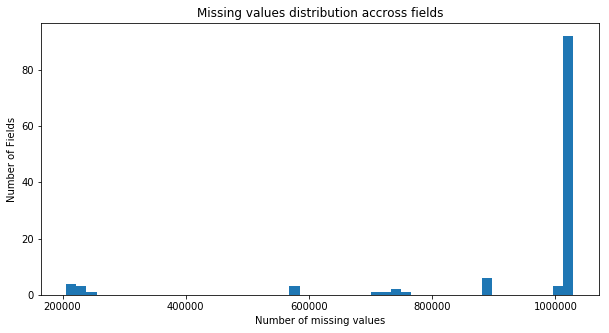

In [23]:
nutrition_facts_df.isnull().sum().plot(kind='hist', figsize=(10,5),bins=50)
plt.title('Missing values distribution accross fields')
plt.xlabel('Number of missing values')
plt.ylabel('Number of Fields')
plt.show()

Lots of fields have many missing values. Our main objective is to ignore the fields that constitute this huge peak of missing values, since they are almost entirely empty, as shown in the plot above.   
We tune the threshold by trial and error to have a satisfactory result. We settle for a threshold of **maximum 20% of missing values**. 

In [24]:
# 20% threshold
missing_values_threshold = len(nutrition_facts_df)*0.2
nutrition_facts_thresh_df = nutrition_facts_df.dropna(axis=1, thresh= missing_values_threshold, how='all')
nutrition_facts_thresh_df = nutrition_facts_thresh_df.dropna(axis=0, how='all')

print('There are now {:,} rows '.format(nutrition_facts_thresh_df.shape[0]) + 'and {} columns left.'.format(nutrition_facts_thresh_df.shape[1]))

There are now 858,066 rows and 16 columns left.


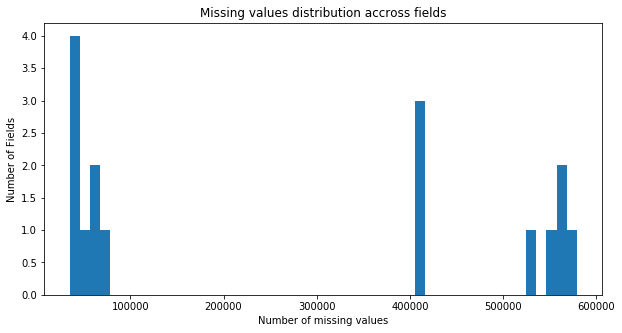

In [25]:
nutrition_facts_thresh_df.isnull().sum().plot(kind='hist', figsize=(10,5),bins=50)
plt.title('Missing values distribution accross fields')
plt.xlabel('Number of missing values')
plt.ylabel('Number of Fields')
plt.show()

We will see the total number of missing values for each field in the dataset after filtering: 

In [26]:
nutrition_facts_thresh_df.isnull().sum().sort_values()

energy_100g                                 34798
proteins_100g                               37660
fat_100g                                    39538
carbohydrates_100g                          39580
sugars_100g                                 53652
salt_100g                                   57446
sodium_100g                                 57496
saturated-fat_100g                          69216
additives_n                                409303
ingredients_from_palm_oil_n                409303
ingredients_that_may_be_from_palm_oil_n    409303
nova_group                                 535314
fiber_100g                                 555632
nutrition-score-fr_100g                    566171
nutrition-score-uk_100g                    566171
serving_quantity                           578992
dtype: int64

In [27]:
print ("We have now {} samples with {} fields".format(nutrition_facts_thresh_df.shape[0],
                                                         nutrition_facts_thresh_df.shape[1]))

We have now 858066 samples with 16 fields


This is a good way of decreasing the number of NaNs in the nutrients columns. Putting the threshold higher would remove the nutrition score columns. 

After dealing with the missing values, let's check the statistics of our data. 

#### Looking at the stats!

In [28]:
nutrition_facts_thresh_df.describe()

,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,2.790740e+05,448763.000000,448763.000000,448763.000000,322752.000000,8.232680e+05,8.185280e+05,7.888500e+05,818486.000000,8.044140e+05,3.024340e+05,8.204060e+05,8.006200e+05,8.005700e+05,291895.000000,291895.000000
mean,3.981421e+16,1.622360,0.027250,0.071837,3.582726,8.096463e+36,2.480363e+01,1.102112e+01,29.827826,1.987600e+01,1.751223e+02,1.167384e+02,1.037326e+02,4.168479e+01,9.219976,9.000339
std,2.103283e+19,2.349457,0.164745,0.316389,0.847597,7.346254e+39,9.672390e+03,5.054040e+03,952.959274,5.100999e+03,9.257557e+04,9.804840e+04,9.040146e+04,3.616216e+04,8.806932,9.272182
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.786000e+01,-2.000000e+01,-8.000000e+02,0.000000e+00,0.000000e+00,-15.000000,-15.000000
25%,2.800000e+01,0.000000,0.000000,0.000000,3.000000,4.310000e+02,6.000000e-01,1.000000e-01,3.570000,8.000000e-01,0.000000e+00,1.200000e+00,6.000000e-02,2.000000e-02,2.000000,1.000000
50%,4.950000e+01,1.000000,0.000000,0.000000,4.000000,1.100000e+03,6.850000e+00,1.900000e+00,15.300000,4.000000e+00,1.600000e+00,5.710000e+00,5.207000e-01,2.032000e-01,10.000000,9.000000
75%,1.130000e+02,2.000000,0.000000,0.000000,4.000000,1.674000e+03,2.143000e+01,7.400000e+00,54.000000,2.000000e+01,3.600000e+00,1.200000e+01,1.350000e+00,5.283200e-01,16.000000,17.000000
max,1.111111e+22,38.000000,3.000000,6.000000,4.000000,6.665559e+42,8.748748e+06,4.488758e+06,857855.000000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,40.000000,40.000000


A quick look at the stats shows some products have corrupted data. The maximmum value of most fields is extremely large, although it should be at most equal to 100g, when considering nutrients. These outliers generate high averages and greatly increase the standard deviation of the data. 

Since we want to estimate the products' nutrition scores, let us check that the provided nutrition scores are reliable:

In [29]:
nutrition_facts_thresh_df.describe().iloc[:,-2:]

,nutrition-score-fr_100g,nutrition-score-uk_100g
count,291895.000000,291895.000000
mean,9.219976,9.000339
std,8.806932,9.272182
min,-15.000000,-15.000000
25%,2.000000,1.000000
50%,10.000000,9.000000
75%,16.000000,17.000000
max,40.000000,40.000000


The data contained by the nutrition scores seems clean. We can rely on it to build a model!

It seems that there is no clear difference between the `nutrition-score-fr_100g` and `nutrition-score-uk_100g`. Let's verify this:

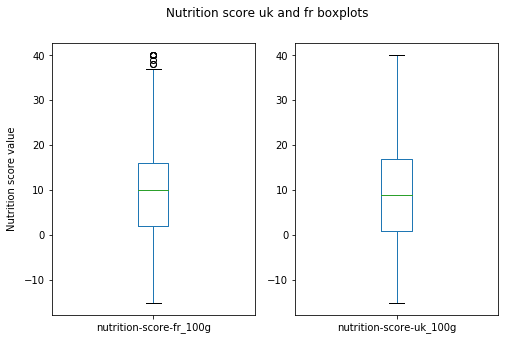

In [30]:
nutrition_facts_thresh_df[['nutrition-score-fr_100g','nutrition-score-uk_100g']]\
    .select_dtypes(include=float).plot(kind='box', subplots=True, title='Nutrition score uk and fr boxplots', figsize=(8,5))
plt.ylabel('Nutrition score value',labelpad=250)
plt.show()

As expected, the two scores have the similar distributions, with some outliers in the `nutrition-score-fr_100g`.

It means we need to clean up the remaining fields containing information about the nutrients. 

#### Dealing with outliers

After visualizing the stats, we saw a huge number of outliers in the dataset when looking to the min, max, mean and standard deviation of each feature.
All the ingredient features should have a reasonable value <=100g except the energy which is expressed in kJ. 

First, the column `serving_quantity` is not an ingredient. It can be dropped 

In [31]:
nutrition_facts_thresh_df=nutrition_facts_thresh_df.drop(columns=['serving_quantity'])

In [32]:
# storing the columns fields in a list
fields=list(nutrition_facts_thresh_df.columns)

Let us now remove the outliers. All nutrition features should have a value <=100g (except `energy_100g`):

In [33]:
nutrition_facts_clean_df= nutrition_facts_thresh_df[(nutrition_facts_thresh_df
                                                      [nutrition_facts_thresh_df.columns.difference(['energy_100g'])] <= 100.0).all(1)]

Negative values can not be possible. Except for the nutrition score that is by definition defined between -14 and 40 

In [34]:
nutrition_facts_clean_df = nutrition_facts_clean_df[
    (nutrition_facts_clean_df[nutrition_facts_clean_df.columns.difference(['nutrition_score_fr_100g', 'nutrition_score_uk_100g'])] >= 0).all(1)]

In [35]:
print("We have only {} rows left".format(nutrition_facts_clean_df.shape[0]))

We have only 78071 rows left


We lost a huge number of rows by removing the outliers. The dataset is highly corrupted in terms of ingredients.  We are going to see later if this number of samples is enough to have significant results. 

In [36]:
nutrition_facts_clean_df.head(10)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,
0000000043595,0.0,0.0,0.0,3.0,1255.0,0.00,0.00,83.33,66.670,10.000,0.00,0.00000,0.000000,3.0,3.0
0000000274722,2.0,0.0,0.0,4.0,450.0,2.20,0.90,15.30,0.500,0.500,6.80,0.70000,0.280000,0.0,0.0
0000000491228,4.0,0.0,2.0,4.0,1952.4,15.30,11.20,75.50,69.800,0.100,6.80,0.50000,0.200000,2.0,2.0
0000001938067,3.0,0.0,0.0,4.0,1090.0,10.70,2.00,38.70,24.700,2.000,3.33,0.64700,0.000259,5.0,5.0
0000007020254,3.0,0.0,0.0,4.0,213.0,0.00,0.00,14.00,0.000,0.000,0.00,1.00000,0.400000,12.0,4.0
0000008237798,9.0,0.0,1.0,4.0,478.0,6.79,2.86,7.86,0.714,0.357,5.36,0.49900,0.000200,0.0,0.0
0000010206515,5.0,0.0,2.0,4.0,1720.0,6.42,3.53,87.86,81.670,0.000,0.03,0.10000,0.040000,18.0,18.0
0000012167005,7.0,0.0,0.0,4.0,536.0,6.00,1.00,50.00,19.000,1.000,7.00,0.00000,0.000000,0.0,0.0
0000020043131,0.0,0.0,0.0,3.0,1527.0,1.18,0.00,71.76,4.710,2.400,12.94,1.19634,0.478536,3.0,3.0


We lost a huge number of rows but the dataset is now very clean !! 

### Data exploration <a class="anchor" id="q1_dataexploration"></a> 

Now we have a clean dataset. Our strategy to find the impact of each variable on the nutrition score is the following: 

* 1) Correlation analysis between the variables 
* 2) Performing ordinary least square (OLS) regression using statsmodel 
* 3) Coefficient analysis


Before analyzing the impact of our variables on the nutrition score, we need to normalize our data by removing the mean and dividing by the standard deviation.

In [37]:
nutrition_facts_clean_df = nutrition_facts_clean_df.select_dtypes(include=float).transform(lambda x: (x - x.mean()) / x.std())

We can check now if the mean of our variables is close to zero and the standard deviation is close to 1. 

In [38]:
nutrition_facts_clean_df.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04,7.807100e+04
mean,6.290883e-15,-6.921440e-14,4.197123e-14,-6.139081e-15,-2.868631e-15,-1.669669e-15,3.505025e-14,-1.048612e-14,1.871884e-15,9.878228e-15,-2.435423e-15,-2.756731e-15,-5.991000e-14,-2.124807e-15,-1.786043e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.442926e-01,-2.383103e-01,-3.043543e-01,-3.474574e+00,-1.569488e+00,-9.092928e-01,-7.409219e-01,-1.153267e+00,-7.988606e-01,-6.657208e-01,-9.404651e-01,-3.743867e-01,-3.725770e-01,-1.428990e+00,-1.322983e+00
25%,-8.442926e-01,-2.383103e-01,-3.043543e-01,-7.920773e-01,-8.642243e-01,-7.691717e-01,-6.766769e-01,-9.252893e-01,-7.253942e-01,-6.657208e-01,-6.864351e-01,-3.354521e-01,-3.391922e-01,-1.024899e+00,-9.376656e-01
50%,-4.354073e-01,-2.383103e-01,-3.043543e-01,5.491713e-01,-8.956940e-02,-3.021012e-01,-3.683008e-01,-3.086282e-01,-4.892521e-01,-3.029192e-01,-2.223418e-01,-1.440237e-01,-1.388833e-01,5.267729e-02,-3.859052e-02
75%,3.823634e-01,-2.383103e-01,-3.043543e-01,5.491713e-01,7.746629e-01,4.919187e-01,3.126964e-01,9.022700e-01,4.917870e-01,2.273293e-01,2.441941e-01,6.362744e-02,6.142557e-02,7.261623e-01,7.320453e-01
max,1.469335e+01,8.379163e+00,1.372374e+01,5.491713e-01,2.202595e+01,4.929088e+00,1.210808e+01,2.584073e+00,4.448741e+00,2.724209e+01,1.115039e+01,3.207111e+01,3.301223e+01,3.958891e+00,3.557710e+00


Great! our data is now ready for the analysis on the impact of our variables on the nutrition score.

Before doing so, let's see the correlation between variables visualized in a heatmap.

#### Correlation analysis

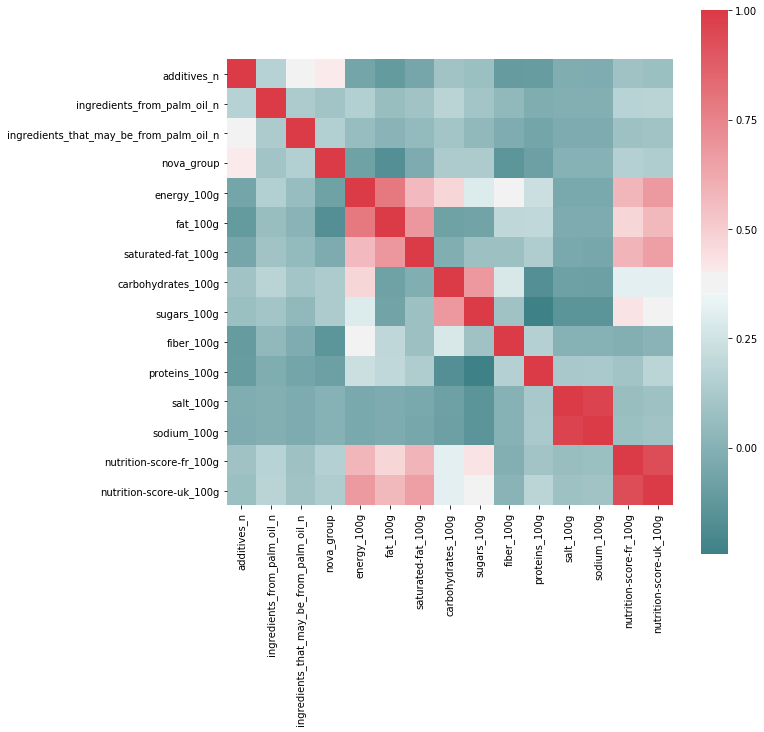

In [39]:
correlation_variables = nutrition_facts_clean_df.corr(method = "pearson")

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_variables, mask=np.zeros_like(correlation_variables, dtype=np.bool), 
            cmap=sns.diverging_palette(200, 10, as_cmap=True), square=True, ax=ax)

From the plot of correlation above we can confirm first that `nutrition-score-fr_100g` and `nutrition-score-uk_100g` are highly correlated.    
We can see also a  correlation equal to 1 between `sodium_100g` and `salt_100g` (obviously). This is why we will drop the column `sodium_100g` to avoid the redundancy. 

In [40]:
#We drop sodium column. 
nutrition_facts_clean_df=nutrition_facts_clean_df.drop(columns=['sodium_100g'])
fields_left=nutrition_facts_clean_df.columns

In [41]:
#We drop one of the nutrition scores 
nutrition_facts_clean_df=nutrition_facts_clean_df.drop(columns=['nutrition-score-uk_100g'])

In [42]:
fields_left=nutrition_facts_clean_df.columns

Let's see the heatmap again. 

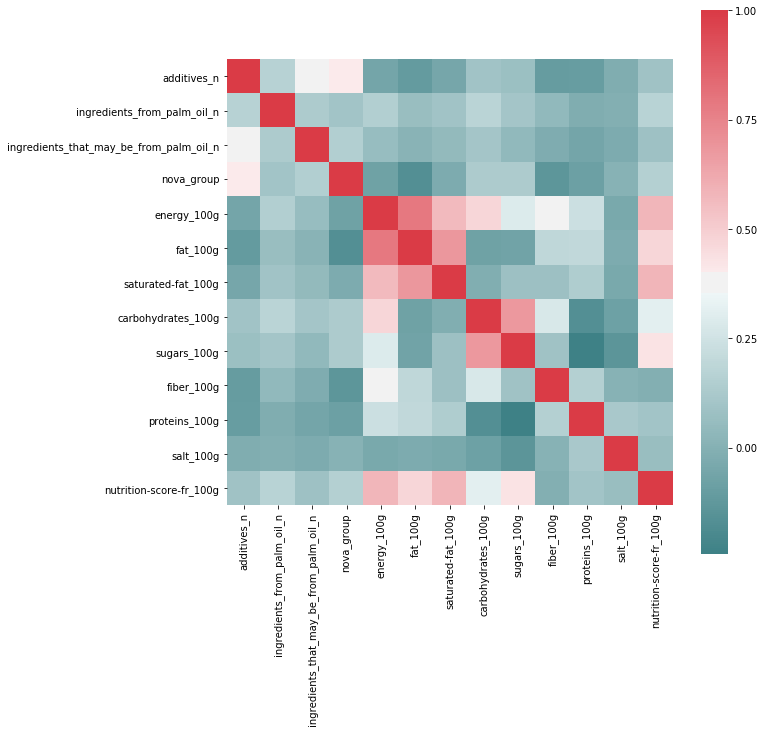

In [43]:
#calculating pearson correlation
correlation_variables = nutrition_facts_clean_df.corr(method = "pearson")

f, ax = plt.subplots(figsize=(10, 10))

#we draw the heatmap using seaborn
sns.heatmap(correlation_variables, mask=np.zeros_like(correlation_variables, dtype=np.bool),cmap=sns.diverging_palette(200, 10, as_cmap=True), square=True, ax=ax)

By looking at the heatmap, we can already see that `energey_100g`, `fat_100g`, `saturated_fat_100g` and `sugar_100g` have the highest correlation on the nutrition score.


Now everything is ready. What we want to do is to find the impact of each ingredient on the nutrition score. One way to do that is using regression. It allows us to see the impact of each variable on this score by looking at the weights. 

#### OLS Regression

Let's prepare our formula for the regression: 

We rename the columns by replacing '-' by '\_'. This will allow us to create the formula for the statsmodel regression since '-' is interpreted as a math symbol while defining the formula as a string. The following cells perform the regression.

In [44]:
for field in fields: 
    nutrition_facts_clean_df = nutrition_facts_clean_df.rename(columns={field: field.replace('-','_')})
fields=nutrition_facts_clean_df.columns

In [45]:
nutrition_facts_clean_df.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,
0000000043595,-0.844293,-0.23831,-0.304354,-0.792077,0.013886,-0.909293,-0.740922,1.961058,2.699715,2.125061,-0.940465,-0.374387,-1.024899
0000000274722,-0.026522,-0.23831,-0.304354,0.549171,-1.001744,-0.780848,-0.625281,-0.581454,-0.772623,-0.526182,-0.109982,-0.147268,-1.428990
0000000491228,0.791249,-0.23831,4.371676,0.549171,0.893763,-0.016020,0.698166,1.668425,2.863965,-0.637813,-0.109982,-0.212159,-1.159596
0000001938067,0.382363,-0.23831,-0.304354,0.549171,-0.194287,-0.284586,-0.483942,0.293084,0.497297,-0.107564,-0.533773,-0.164464,-0.755505
0000007020254,0.382363,-0.23831,-0.304354,0.549171,-1.300756,-0.909293,-0.740922,-0.630039,-0.798861,-0.665721,-0.940465,-0.049932,0.187374


In [46]:
# OLS regression formula 
fields_left=nutrition_facts_clean_df.columns
formula_string="nutrition_score_fr_100g ~ "
for field in fields_left[:-1]:
    formula_string=formula_string+field+"+"
formula_string=formula_string[:-1]
formula_string

'nutrition_score_fr_100g ~ additives_n+ingredients_from_palm_oil_n+ingredients_that_may_be_from_palm_oil_n+nova_group+energy_100g+fat_100g+saturated_fat_100g+carbohydrates_100g+sugars_100g+fiber_100g+proteins_100g+salt_100g'

In [47]:
nutrition_score_regression = sm.ols(formula= formula_string, data = nutrition_facts_clean_df)
res = nutrition_score_regression.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition_score_fr_100g   R-squared:                       0.608
Model:                                 OLS   Adj. R-squared:                  0.608
Method:                      Least Squares   F-statistic:                 1.007e+04
Date:                     Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                             21:33:41   Log-Likelihood:                -74254.
No. Observations:                    78071   AIC:                         1.485e+05
Df Residuals:                        78058   BIC:                         1.487e+05
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Results <a class="anchor" id="q1_results"></a> 

Analysing the regression results from the coefficients of each ingredient, we can deduce the impact of these ingredients on the the nutrition score.  

#### Positive coef 
* `sugars_100g` has the highest positive impact nutrition score ~ 0.37  
* `saturated_fat_100g`has the fourth highest impact on nutrition socre ~ 0,36
* `energy_100` has the second highest impact on the nutrition score ~ 0.20 
* `salt_100g` with a coef ~ 0.14
* `fat_100g` with a coef ~ 0.13
* `nova_group`with a coef ~ 0.11


#### Negative coef 
* `fiber_100g` has the highest negative impact on the nutrition score ~-0.18 

#### Zero coef
* `ingredients_from_palm_oil_n ` , `additives_n  ` and `carbohydrates_100g` don't have any impact on the nutrition score 

From the french nutrition score datasheet page 24, we see that the highest the nutrition score is, the lowest the nutritional quality. We can then deduce that all products with a high percentage of **energy**, **sugar**, **salt**, and **saturated fat** are generally all unhealthy, while products with a high percentage of **fibers** are usually healthy. The rest of the ingredients do not have a huge impact on the nutrition score.  
By analyzing the p-value we can deduce that our variables are statistically significant except for the `ingredients_that_may_be_from_palm_oil_n`.    
The number of samples we have in hand after dropping the outliers and NaNs is enough to have significant results.

One of the features which seems to have a high impact on the nutrition score is the **nova group**. The values of this group are {1,2,3,4}

* Group 1 - Unprocessed or minimally processed foods: Unprocessed (or natural) foods are edible parts of plants (seeds, fruits, leaves, stems, roots) or of animals (muscle, offal, eggs, milk), and also fungi, algae and water, after separation from nature.
* Group 2 - Processed culinary ingredients: Processed culinary ingredients, such as oils, butter, sugar and salt, are substances derived from Group 1 foods or from nature by processes that include pressing, refining, grinding, milling and drying.
* Group 3 - Processed foods: Processed foods, such as bottled vegetables, canned fish, fruits in syrup, cheeses and freshly made breads, are made essentially by adding salt, oil, sugar or other substances from Group 2 to Group 1 foods. 
* Group 4 - Ultra-processed food and drink products: Ultra-processed foods, such as soft drinks, sweet or savoury packaged snacks, reconstituted meat products and pre-prepared frozen dishes.  

Beeing in a higher group leads also to a high nutrition score and then low nutritional quality.  

#### Conclusion

We can conclude that the analysis of the nutrients on the nutrition score is giving satisfactory results. The main problem we encontered here is the missing values. We were forced to lose a huge number of rows and features from the dataset. 

The fact that many values are missing can also be due to the fact that nutrients that are not present in a product are ignored when adding a product to the dataset. This creates a NaN instead of just explicitly specifying a value of zero. We therefore do not know if the NaN values can be interpreted as zeros or as actual missing values. 

## Question 2: Comparing bio vs. normal products, is there a real difference in composition? <a class="anchor" id="q2"></a> 

A lot of products claim to be bio. Different terms are used depending on the location (organic, bio, ...), but overall they all refer to the same fact that the product was mostly produced in compliance with the standards of [organic farming](https://en.wikipedia.org/wiki/Organic_farming). In the common knowledge, people often claim that organic or bio products are healthier than non-organic products.

In the upcoming analysis, we will try to investigate whether this statement is quantitavely true or if sometimes companies take advantage of the "bio" acronym to gain market shares.

We will conduct this analysis by investigating different columns of interest: 

* We have access to two different nutritional scores. We will try to investigate whether differences can be observed with respect to this column, i.e if bio/organic products tend to obtain better nutritional scores than standard products.
    - In addition, some bio products may obtain bad nutritional scores. We will try to pinpoint why some bio products would still get such bad scores.
    
    
* As stated above, organic products should undergo as little tratment as possible, inducing a more natural product. This should directly be represented by a lower capacity in additives. Hence as a first step we will assess whether there is a different in additives between bio and normal products.

### Data exploration <a class="anchor" id="q2_dataexploration"></a> 

Let's see if we can separate the *bio/organic* products from the regular ones.

Some product contain words such as 'bio', 'biologic', 'organic' in their `product_name`, so this can be use to distinguish them from normal products. In addition, the dataset contains the columns `labels`, `labels_tags` and `labels_en`, which contain information about quality labels/certifications which also include bio products.

Thus, these columns can be used to split the dataset into 'bio' products and regular products. We will seach for keywords in these columns to determine if a product is bio:

In [48]:
bio_keywords = ['bio', 'organi'] # bio --> bio, biological, biologique, etc.; organi --> organic, organique

contains_bio_keywords = lambda x: any([(kw in str(x)) for kw in bio_keywords])

#food_facts_df.dropna(subset=['product_name'], inplace=True)

In [49]:
# Check for products matching the bio keywords in the 4 columns
bio_products = (food_facts_df['product_name'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_tags'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_en'].apply(contains_bio_keywords))

bio_df = food_facts_df[bio_products]

non_bio_df = food_facts_df[~bio_products]

print('There are {} bio products, and {} non-bio products.'.format(bio_df.shape[0], non_bio_df.shape[0]))
bio_df.head(5)

There are 73102 bio products, and 956136 non-bio products.


,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000001427,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1550231727,2019-02-15T11:55:27Z,1550231732,2019-02-15T11:55:32Z,Pain de maïs bio,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000000000429,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1567080029,2019-08-29T12:00:29Z,1567080749,2019-08-29T12:12:29Z,Jus de Pommes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000000001011,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1568142714,2019-09-10T19:11:54Z,1568143389,2019-09-10T19:23:09Z,Fromage blanc fermier de chèvre au lait entier,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000014595,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1520321992,2018-03-06T07:39:52Z,1561463802,2019-06-25T11:56:42Z,Pâte de fruit fraise,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1545997008,2018-12-28T11:36:48Z,Organic Salted Nut Mix,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nutritional score analysis

We now have a dataset split into bio and regular products, although the 2 categories are highly unbalanced. Let's analyze quickly if there is a difference in their nutritional score. The French nutritional score (`nutrition_grade_fr`) ranks the products from 'A' (best) to 'E' (worst) depending on their composition. so let's have a look at the relative distribution of those grades among the bio and regular products:

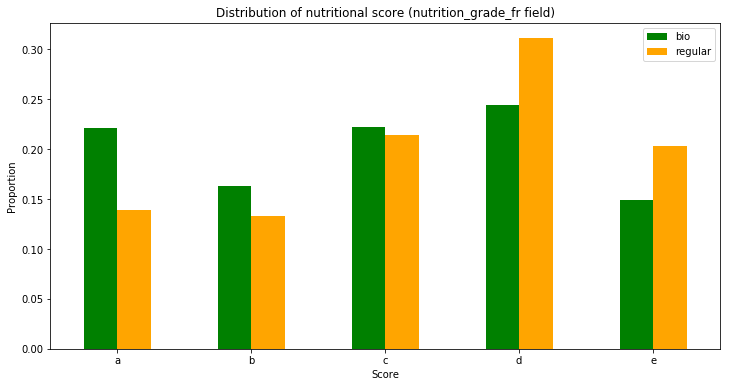

In [50]:
score_field = 'nutrition_grade_fr'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=0, figsize=(12, 6))

plt.title('Distribution of nutritional score (nutrition_grade_fr field)')
plt.xlabel('Score')
plt.ylabel('Proportion')

plt.show()

There is a clear difference in the distribution of the nutritional score. The proportion of bio product with grade 'A' and 'B' is much higher than that of the regular products. Conversaly, there are less bio products with grade 'D' and 'E'. So overall, it seems that the bio products are healthier than the regular ones. 

There is another nutritional score indicated in the dataset, which is the UK one (`nutrition-score-uk_100g`). Let's see if the trend we observed is similar:

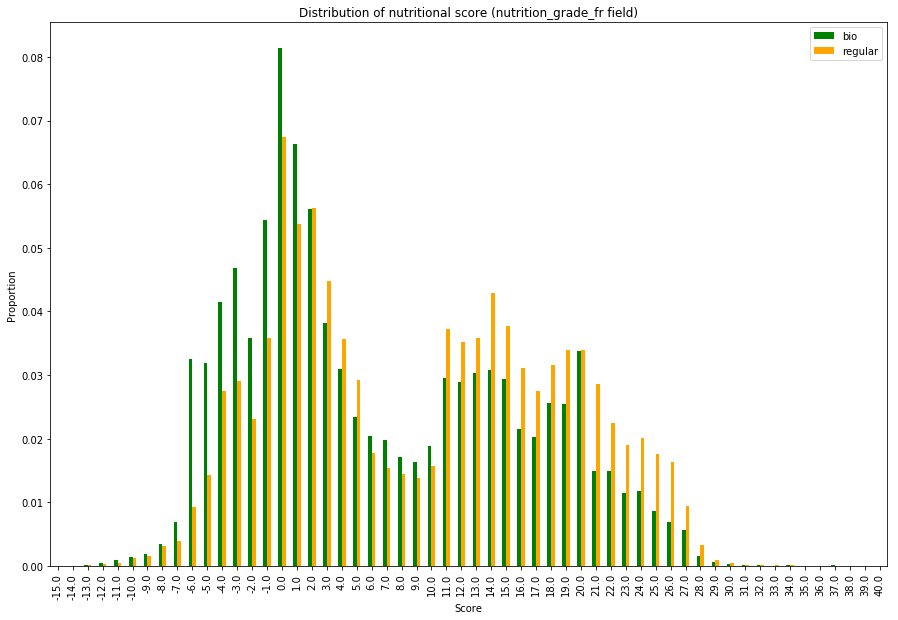

In [51]:
score_field = 'nutrition-score-uk_100g'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=90, figsize=(15, 10))

plt.title('Distribution of nutritional score (nutrition_grade_fr field)')
plt.xlabel('Score')
plt.ylabel('Proportion')

plt.show()

The same observation can be made for the uk nutritional score (`nutrition-score-uk_100g`): the distribution of bio product shows that in proportion, they are more bio product that have a good nutritional score, and there are more regular products with a bad nutritional score.

Now, let's have a look at the `nova_group` column. As presented for Q1, the nova group correspond to the level of processing of the food products. Let's see how bio and regular products compare:

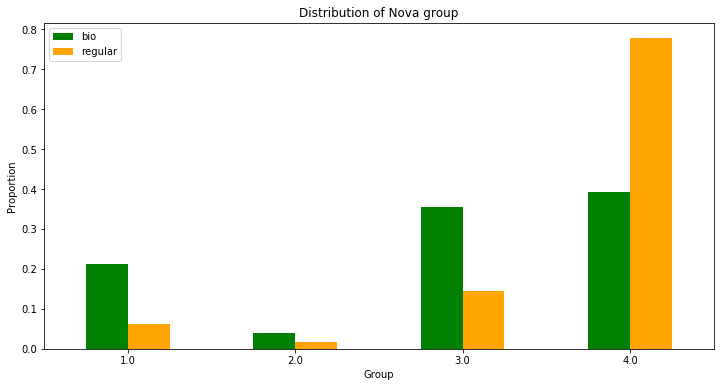

In [52]:
score_field = 'nova_group'

scores_df = pd.DataFrame([bio_df[score_field].value_counts(normalize=True).sort_index().rename('bio'),
             non_bio_df[score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=0, figsize=(12, 6))

plt.title('Distribution of Nova group')
plt.xlabel('Group')
plt.ylabel('Proportion')

plt.show()

Interestingly, there are in proportion a lot more unprocessed product that are bio. Conversaly, 80% of regular products are in the 4th category, which is the one that corresponds to the most processed products, which are in general the less healthy.

### Results <a class="anchor" id="q2_results"></a> 

We were able to separate products that are bio from the product that are not. Although we obtain two unbalanced sets of products, we obtained encouraging results, so we are going to keep investigating the question 'bio vs. regular products'.

### Additives analysis

First we extract the product_name and additives_tags columns for the bio and non-bio dataframes computed above.

In [53]:
bio_additives_df = bio_df[['product_name','additives_en']]
non_bio_additives_df = non_bio_df[['product_name','additives_en']]

In [54]:
bio_additives_df.head(10)

,product_name,additives_en
code,,
0000000001427,Pain de maïs bio,NaN
000000000429,Jus de Pommes,NaN
000000001011,Fromage blanc fermier de chèvre au lait entier,NaN
0000000014595,Pâte de fruit fraise,NaN
0000000016087,Organic Salted Nut Mix,NaN
0000000016094,Organic Polenta,NaN
0000000016117,Organic Long Grain White Rice,NaN
0000000016124,Organic Muesli,E307c - Alpha-tocopherol
0000000016193,Organic Dark Chocolate Minis,NaN


We remark that a lot of products do not contain any additives. One should be careful with this as this could be either that the product indeed does not contain any additives, or simply because the data is missing this information.

As we are trying to compare the different additives present in the bio and normal products and not quantizing how many products of these two categories contain additives, we can drop the rows not containing this information.

In [55]:
bio_additives_df = bio_additives_df.dropna()
non_bio_additives_df = non_bio_additives_df.dropna()
print("Length of bio dataset : {}\nLength of non-bio dataset : {}" .format(len(bio_additives_df), len(non_bio_additives_df)))

Length of bio dataset : 9494
Length of non-bio dataset : 233740


In [56]:
bio_additives_df.head()

,product_name,additives_en
code,,
0000000016124,Organic Muesli,E307c - Alpha-tocopherol
0000000018517,Seventh Heaven Organic Trail Mix,"E322 - Lecithins,E322i - Lecithin"
0000000035286,Organic Shoyu,E1510 - Ethanon
0000000035293,Organic Wheat-Free Tamari,E1510 - Ethanon
0002000000776,Fondant de saumon,"E336 - Potassium tartrates,E336i - Monopotassi..."


We observe a highly unbalanced dataset between products being organic and products not being organic. This will be taken into account for the upcoming analysis.

The additives_tags contains a string being a list. Let's process this column to enable a list representation, and then exploding this column to have a single element per row in this column.

In [57]:
bio_additives_df['additives_en'] = bio_additives_df['additives_en'].apply(lambda x: list(x.split(",")))
bio_additives_df_exploded = bio_additives_df.explode('additives_en')

non_bio_additives_df['additives_en'] = non_bio_additives_df['additives_en'].apply(lambda x: list(x.split(",")))
non_bio_additives_df_exploded = non_bio_additives_df.explode('additives_en')

In [58]:
bio_additives_df_exploded.head(10)

,product_name,additives_en
code,,
0000000016124,Organic Muesli,E307c - Alpha-tocopherol
0000000018517,Seventh Heaven Organic Trail Mix,E322 - Lecithins
0000000018517,Seventh Heaven Organic Trail Mix,E322i - Lecithin
0000000035286,Organic Shoyu,E1510 - Ethanon
0000000035293,Organic Wheat-Free Tamari,E1510 - Ethanon
0002000000776,Fondant de saumon,E336 - Potassium tartrates
0002000000776,Fondant de saumon,E336i - Monopotassium tartrate
0002000002466,2 MINI BAGUETTES SANS GLUTEN,E412 - Guar gum
0002000002466,2 MINI BAGUETTES SANS GLUTEN,E415 - Xanthan gum


In [59]:
bio_additives_df = bio_additives_df_exploded.groupby('additives_en') \
                                                     .count() \
                                                     .sort_values('product_name', ascending=False) \
                                                     .reset_index() \
                                                     .rename(columns={'additives_en' : 'additive', "product_name" : "count"})
    
non_bio_additives_df = non_bio_additives_df_exploded.groupby('additives_en') \
                                                             .count() \
                                                             .sort_values('product_name', ascending=False) \
                                                             .reset_index() \
                                                             .rename(columns={'additives_en' : 'additive', "product_name" : "count"})

First let's observe the 5 most used additive in Bio and non-Bio products, which is not biased by the unbalancing of the dataset.

In [60]:
most_used_bio = bio_additives_df['additive'][:5]
most_used_normal = non_bio_additives_df['additive'][:5]
print("The most used additives for bio products are : \n{} \n\n\n"
      "The most used additives for normal products are : \n{}" .format(most_used_bio, most_used_normal))

The most used additives for bio products are : 
0            E322 - Lecithins
1          E330 - Citric acid
2    E500 - Sodium carbonates
3              E440 - Pectins
4            E322i - Lecithin
Name: additive, dtype: object 


The most used additives for normal products are : 
0                              E330 - Citric acid
1                                E322 - Lecithins
2                                E322i - Lecithin
3                              E415 - Xanthan gum
4    E471 - Mono- and diglycerides of fatty acids
Name: additive, dtype: object


We already observe a difference from the top 5 used additives for bio product vs normal product. Let's try to visualize the global picture

First we compute the proportion of each additive in its own dataset

In [61]:
bio_additives_df['proportion'] = bio_additives_df['count'] / bio_additives_df['count'].sum()
non_bio_additives_df['proportion'] = non_bio_additives_df['count'] / non_bio_additives_df['count'].sum()

Let's observe the results, taking the normal products as a reference.

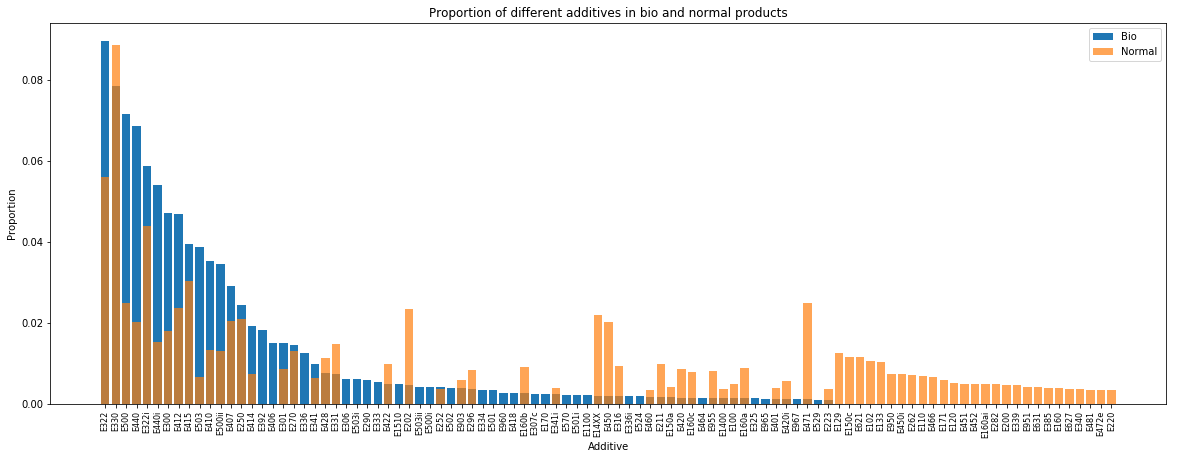

In [62]:
n_to_plot = 70

figure = plt.figure(figsize=(20,7))

additive_tag_bio = bio_additives_df.additive.apply(lambda x: x.split(" ")[0])
additive_tag_normal = non_bio_additives_df.additive.apply(lambda x: x.split(" ")[0])

plt.bar(additive_tag_bio[:n_to_plot], bio_additives_df.proportion[:n_to_plot], label='Bio')
plt.bar(additive_tag_normal[:n_to_plot], non_bio_additives_df.proportion[:n_to_plot], label='Normal', alpha=0.7)

plt.title('Proportion of different additives in bio and normal products')
plt.xlabel('Additive')
plt.ylabel('Proportion')
plt.legend()
plt.xticks(rotation = (90), fontsize = 8, va='top')
plt.show()

Many different analysis can be conducted from this graph.

* Let's analyze one of the spike present for the bio products and not for the normal products. One of the biggest is with the E440 and E440i additives. With a quick search online, we determine that this specific additive is [Pectin](https://en.wikipedia.org/wiki/Pectin). This specific additive is also used for [medicine](https://www.webmd.com/vitamins/ai/ingredientmono-500/pectin) and is hence not harmful at all.

* Another big peak present for bio products and not for normal products is with the E300 additive. Again, a quick search online revealed that this additive represent [ascorbic acid](https://www.webmd.com/drugs/2/drug-322/ascorbic-acid-vitamin-c-oral/details) and is known to be an antioxident, hence again not harmful at all.

* We observe that going down the most present additives, the normal products contains some additives that are not present at all in bio products. Let's observe some of them a bit deeper
    - Let's observe the E471 additive which is a big peak for the non-bio products. We found that this additive represent the Mono- and diglycerides of fatty acids. It was set not to be harmful but is still prohibited in biological food in the EU due to its source from fatty acids ([source in french](https://www.additifs-alimentaires.net/E471.php)). The presence of this additive in the dataset even if it is prohibited in the EU may be explained by the fact that it may not be prohibited in other countries, such as in the United States or also that some products may have had contacts to other non-bio products and hence have been contaminated with this additive.
    - E450 is another big peak for non-bio products and represents the Diphosphates and Pyrophosphates. These specific products are doubtful as the harmful dosages are not known ([source in french](https://additifs-alimentaires.net/E450.php)). This is hence the first additive which is known to be dangerous, and being present in normal products and not in bio products.

### Primary results

We observe that there is a significant difference in terms of present additives between the two categories of bio and non-bio products. This is encouraging for future work on the differentiation of these two categories. 
Here we presented a **non-exhaustive** list of the difference with respect to a few additives selected visually on the graph. Future work include the batch processing of such additives which are often represented by groups which are cited on [this](https://en.wikipedia.org/wiki/E_number) wikipedia page. Next steps is to produce a more robust analysis with respect to these groups

## Question 3: What are the levels of interdependencies between nations based on their production and importations? <a class="anchor" id="q3"></a> 

### Additional cleaning <a class="anchor" id="q3_additionalcleaning"></a> 

Let us first identify the [fields](https://static.openfoodfacts.org/data/data-fields.txt) that are relevant to the question:

In [63]:
FIELDS = ['origins',
          'origins_tags',
          'manufacturing_places',
          'manufacturing_places_tags',
          'first_packaging_code_geo',
          'cities',
          'cities_tags',
          'purchase_places',
          'stores',
          'countries',
          'countries_en',
          'countries_tags']

Let us observe the type of information each of them offers: 

In [64]:
for field in FIELDS:
    print('Field: ' + field)
    field_sr = get_field_without_nan(food_facts_df,field)
    print('\t',field_sr.head(4).values)

Field: origins
	 ['France' 'Québec' 'Québec' 'France']
Field: origins_tags
	 ['france' 'quebec' 'quebec' 'france']
Field: manufacturing_places
	 ['France' 'France' 'Brossard Québec' 'Brossard Québec']
Field: manufacturing_places_tags
	 ['france' 'france' 'brossard-quebec' 'brossard-quebec']
Field: first_packaging_code_geo
	 ['47.833333,-0.333333' '47.883333,-2.766667' '49.083333,2.75'
 '47.7,-0.366667']
Field: cities
	 []
Field: cities_tags
	 ['sable-sur-sarthe-sarthe-france' 'bignan-morbihan-france'
 'lagny-le-sec-oise-france' 'daumeray-maine-et-loire-france']
Field: purchase_places
	 ['France' 'Roissy,France' 'Roissy,France' 'France']
Field: stores
	 ['courte paille' 'Marks & Spencer' 'Marks & Spencer' "Sainsbury's"]
Field: countries
	 ['France' 'France' 'France' 'en:France']
Field: countries_en
	 ['France' 'France' 'France' 'France']
Field: countries_tags
	 ['en:france' 'en:france' 'en:france' 'en:france']


An important criterion to select reliable fields is how complete the information is per field. This was already illustrated at the beginning of the notebook, but we show here the fields that are interesting for the question:

In [65]:
# Completeness levels for the full dataset
fields_fill_percentage = get_fields_completeness(food_facts_df,FIELDS,verbose=True)

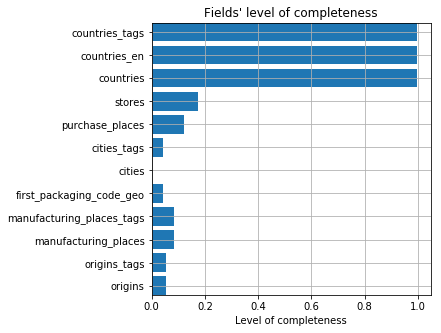

In [66]:
plt.figure(figsize=(5,5))
plt.barh(list(fields_fill_percentage.keys()),list(fields_fill_percentage.values()))
plt.title('Fields\' level of completeness')
plt.xlabel('Level of completeness')
plt.margins(y=0)
plt.grid()

Clearly, the most reliable fields are `countries`, `countries_en` and `countries_tags` since they are almost missing no data! Furthermore, `countries_en` is essentially a cleaned up version of `countries`. However, `countries_tags` is a more reliable representation of the countries. We will therefore definitely use this field. It essentially indicates where the product is sold.

### Data exploration <a class="anchor" id="q3_dataexploration"></a> 

Let us analyze the `countries_tags` field more in depth. Let us see what `unique()` returns for this field:

In [67]:
# Store unique 'countries_tag' 
unique_countries_tag_s = pd.Series(food_facts_df['countries_tags'].dropna().unique())
unique_countries_tag_s.head(10)

0                     en:france
1              en:united-states
2                    en:ireland
3                    en:belgium
4             en:united-kingdom
5    en:france,en:united-states
6                      en:spain
7                     en:canada
8                en:switzerland
9                    en:germany
dtype: object

For an easier inspection of the countries tags, we store all countries in a text file to further verify the integrity of the data. 

In [68]:
def get_unique_values_of_field(df:pd.DataFrame, field='countries_tags', sep=','): 
    '''
    Returns a pd.Series with unique values for the given "field", where the field
    contains multiple values separated by "sep". 

    Procedure (line by line)
    1. Drop nan values from dataset and convert array to a Series.
    2. Split the field's values into list of strings. 
    3. Explode the lists into new rows. 
    4. Reset the index and return the final Series with unique values. 

    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :param sep: sperator to split the values 
    '''
    return pd.Series(pd.Series(df[field].dropna().unique())
        .apply(lambda x : str(x).split(sep)) 
        .explode().unique()).sort_values(ascending=True)\
        .reset_index()[0]

In [69]:
unique_countries_sr = get_unique_values_of_field(food_facts_df,field='countries_tags')

In [70]:
# Store the countries in a text file
with open('data/countries.txt','wb') as file: 
    for i,country in enumerate(unique_countries_sr):
        file.write((country+'\n').encode('utf8'))

The data seems to be clean! Some products exist in different countries. When this is the case, the `countries_tag` field contains a list of countries separated by commas. To really identify unique countries the dataframe should be modified to list a single country per product. In this way, we will exactly know how many products are found in each of them. 

To do so, we need to explode the `countries_tags` to contain a single value instead of a list of countries. This will create a new row which is a duplicate of the original one where the `countries_tags` field contains a single value:

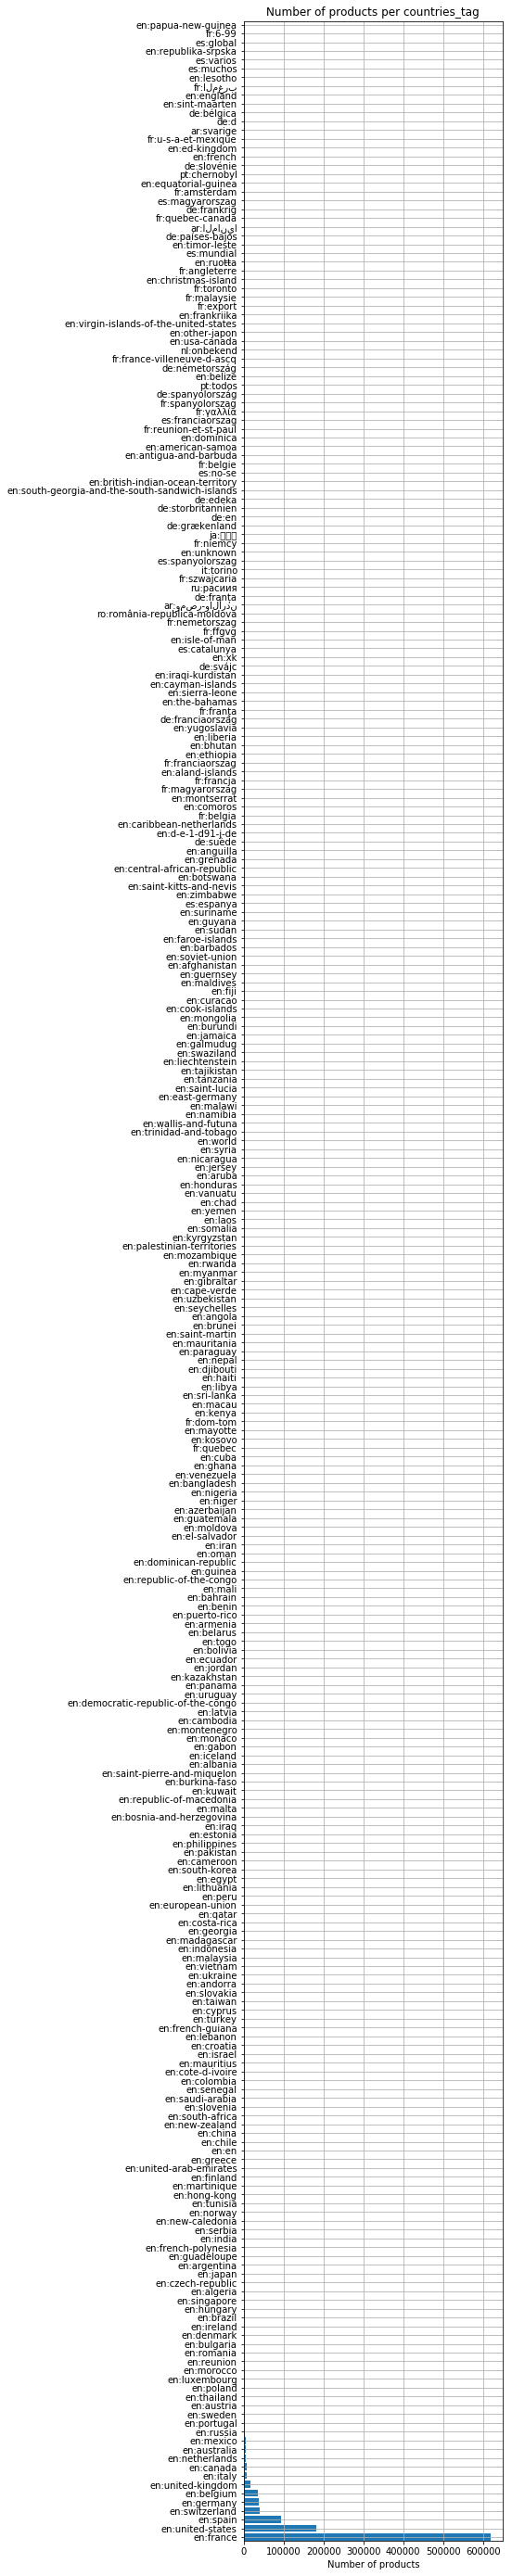

In [71]:
def get_field_value_counts(df:pd.DataFrame, field='countries_tags', sep=','):
    '''
    Count the occurences of the different values of the given "field". 
    The fields containing the specified speratator "sep" are exploded (boom). 

    :param df: dataframe to extract info from
    :param field: field of the database to evaluate
    :param sep: sperator to split the values 
    :return: Series with value count of each value of the 'field'
    '''
    return df[field].dropna().apply(lambda x : str(x).split(sep)).explode().value_counts()

v_counts = get_field_value_counts(food_facts_df,field='countries_tags',sep=',')

plt.figure(figsize=(5,50))
plt.barh(list(v_counts.index),list(v_counts.values))
plt.title('Number of products per countries_tag')
plt.xlabel("Number of products")
plt.margins(y=0)
plt.grid()

The data is extremely poorly distributed. We should therefore base our analysis solely on following countries:

In [72]:
selected_countries_list = ['en:france', 'en:united-states', 'en:switzerland', 'en:germany', 'en:belgium', 'en:united-kingdom']

#### Products spread across countries
An interesting aspect is to see how products are shared across countries. To observe this, we will identify the different countries each product is selled in for the selected list of countries defined in the previous cell. 

Based on the `countries_tag` field, we can extract relations between countries. 

In [73]:
# Copy the dataset
code_country_df = food_facts_df[['countries_tags']].dropna().copy()

# Split the countries tags into lists
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x).split(','))

# Explode the countries (while still promoting peace around the world)
code_country_df = code_country_df.explode('countries_tags').reset_index()

code_country_df.head(2)

,code,countries_tags
0,0000000000017,en:france
1,0000000000031,en:france


In [74]:
# Only keep selected countries
code_country_df = code_country_df[code_country_df['countries_tags'].apply(lambda x : str(x) in selected_countries_list)]

In [75]:
# Only keep individual products present in different countries
code_country_df = code_country_df[code_country_df.duplicated('code',keep=False)] # Mark all duplicates as True.

In [76]:
# Store a list of remaining countries with shared products
exchange_countries = code_country_df['countries_tags'].unique()

In [77]:
# Prepare data frame that will be used to plot the relations between countries
grid_exchange_df = pd.DataFrame(0, index=exchange_countries, columns=exchange_countries)
grid_exchange_df.iloc[:2,:2]

,en:france,en:united-states
en:france,0,0
en:united-states,0,0


In [78]:
# Regroup the countries tags 
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x)+',')        # /!\ adds a " " at the end after grouping 
code_country_df = code_country_df.groupby('code').sum()                                                   # Concat the countries tags
code_country_df['countries_tags'] = code_country_df['countries_tags'].apply(lambda x : str(x).split(',')) # Convert countries tags to lists
code_country_df.head(2)

,countries_tags
code,
0000000031141,"[en:france, en:united-states, ]"
0000000034791,"[en:france, en:united-states, ]"


In [79]:
def populate_grid(x):
    '''
    Populate the grid storing the number of common products
    for each pair of countries. 
    '''
    global grid_exchange_df
    for pair in itertools.product(x[:-1], repeat=2):
        if pair[0] == pair[1]:
            continue
        grid_exchange_df.loc[pair[0],pair[1]] += 1

In [80]:
# Populate the grid (takes a minute)
code_country_df['countries_tags'].apply(populate_grid)

code
0000000031141             None
0000000034791             None
0000000036252             None
0000000038706             None
0000000039529             None
                          ... 
96133262                  None
96133958                  None
9780201379129             None
9900014423142000990001    None
9900162792162001950001    None
Name: countries_tags, Length: 39373, dtype: object

In [81]:
grid_exchange_df 

,en:france,en:united-states,en:germany,en:switzerland,en:united-kingdom,en:belgium
en:france,0,2008,14697,10489,3636,9819
en:united-states,2008,0,97,99,116,56
en:germany,14697,97,0,1761,228,573
en:switzerland,10489,99,1761,0,161,845
en:united-kingdom,3636,116,228,161,0,161
en:belgium,9819,56,573,845,161,0


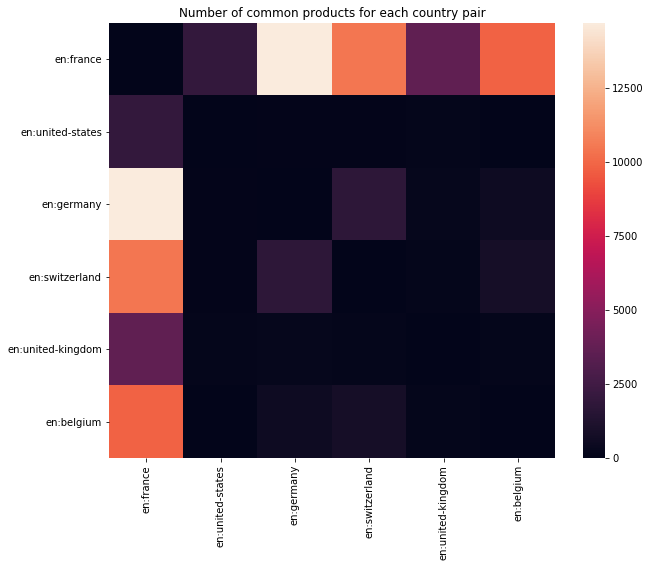

In [82]:
plt.figure(figsize=(10,8))
sns.heatmap(grid_exchange_df) # , vmin=0, vmax=60000 
plt.title('Number of common products for each country pair');

Overall, France shares some of its products with other European countries, as well as with the United States. Some exchanges also appear between Switzerland and Germany. Otherwise, very few common products seem to exist. Since the heat map is a bit hard to read, let us represent this data differently:

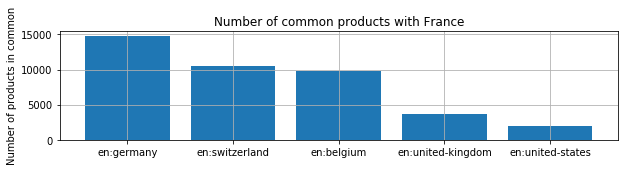

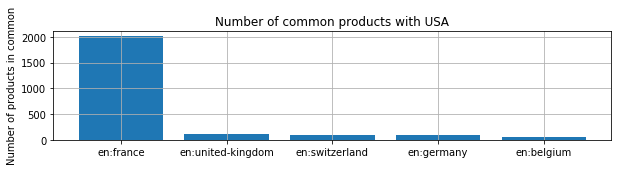

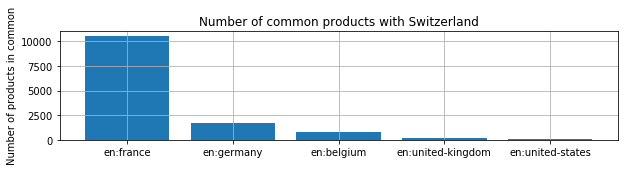

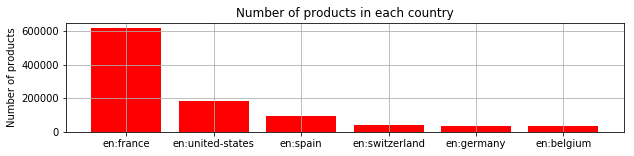

In [83]:
plt.figure(figsize=(10,2))
plt.bar(grid_exchange_df['en:france'].sort_values(ascending=False).iloc[:-1].index,
        grid_exchange_df['en:france'].sort_values(ascending=False).iloc[:-1].values)
plt.title('Number of common products with France')
plt.ylabel('Number of products in common')
plt.grid()
plt.show()

plt.figure(figsize=(10,2))
plt.bar(grid_exchange_df['en:united-states'].sort_values(ascending=False).iloc[:-1].index,
        grid_exchange_df['en:united-states'].sort_values(ascending=False).iloc[:-1].values)
plt.title('Number of common products with USA')
plt.ylabel('Number of products in common')
plt.grid()
plt.show()

plt.figure(figsize=(10,2))
plt.bar(grid_exchange_df['en:switzerland'].sort_values(ascending=False).iloc[:-1].index,
        grid_exchange_df['en:switzerland'].sort_values(ascending=False).iloc[:-1].values)
plt.title('Number of common products with Switzerland')
plt.ylabel('Number of products in common')
plt.grid()
plt.show()

countries_counts_df = pd.DataFrame(v_counts).reset_index().rename(columns={'index':'name','countries_tags':'counts'}).head(6)
plt.figure(figsize=(10,2))
plt.bar(countries_counts_df.name, countries_counts_df.counts,color='r')
plt.title('Number of products in each country')
plt.ylabel('Number of products')
plt.grid()
plt.show()

In the case of France, at most 2.5% of its products can also be found in another country. This proportion is almost neglectable. We should therefore focus our analysis on individual countries. Trying to derive relations between countries, their interdependences is not realistic considering the little information available. We will therefore not further investigate the question of interdependencies between nations. This is not the right dataset for such an analysis. 

### Results <a class="anchor" id="q3_results"></a> 

To conclude, we **will not keep** the question regarding the interdependencies between countries. The data available here does not offer enough insight on this kind of subject. Only five countries have a decent amount of products listed and there is only little information about the products exchanges among them. 

## Complementary dataset <a class="anchor" id="complementarydataset"></a> 

The Open Food Facts dataset is interesting and provides a lot of information about products that are sold in supermarkets. However, one of its limitations is that it mainly contains 'processed food', and no information on raw food such as fresh vegetables, fruits, etc.

For our investigations, we would like to have informations on such products, and hence need to find extra data. We came accross the [Ciqual nutritional composition table](https://www.data.gouv.fr/fr/datasets/table-de-composition-nutritionnelle-des-aliments-ciqual/), which is a dataset containing the composition of food and dishes. The dataset was created by a French certified public organism and the data it contains is very reliable. In particular, it contains the composition data for fruits and vegetables that we are interested in.

In [84]:
CIQUAL_DATASET_PATH = 'data/TableCiqual2017_ExcelFR_2017 11 17.xls'

ciqual_df = pd.read_excel(CIQUAL_DATASET_PATH)
ciqual_df.head(5)

,alim_grp_code,alim_ssgrp_code,alim_ssssgrp_code,alim_grp_nom_fr,alim_ssgrp_nom_fr,alim_ssssgrp_nom_fr,alim_code,alim_nom_fr,alim_nom_fr.1,"Energie, Règlement UE N° 1169/2011 (kcal/100g)",...,Vitamine K1 (µg/100g),Vitamine K2 (µg/100g),Vitamine C (mg/100g),Vitamine B1 ou Thiamine (mg/100g),Vitamine B2 ou Riboflavine (mg/100g),Vitamine B3 ou PP ou Niacine (mg/100g),Vitamine B5 ou Acide pantothénique (mg/100g),Vitamine B6 (mg/100g),Vitamine B9 ou Folates totaux (µg/100g),Vitamine B12 (µg/100g)
0,1,101,0,entrées et plats composés,salades composées et crudités,-,25600,"Céleri rémoulade, préemballé","Céleri rémoulade, préemballé",-,...,-,-,"25,2","< 0,04","< 0,04","0,38","0,28","0,19",28,"< 0,08"
1,1,101,0,entrées et plats composés,salades composées et crudités,-,25601,"Salade de thon et légumes, appertisée, égouttée","Salade de thon et légumes, appertisée, égouttée",-,...,-,-,"2,75","< 0,04","0,053","4,45","< 0,16","0,29",31,"1,45"
2,1,101,0,entrées et plats composés,salades composées et crudités,-,25602,"Salade composée avec viande ou poisson, appert...","Salade composée avec viande ou poisson, appert...",-,...,"9,75",-,-,"0,032","0,022","4,13","0,2","0,12","11,1","1,23"
3,1,101,0,entrées et plats composés,salades composées et crudités,-,25605,Champignon à la grecque,Champignon à la grecque,-,...,-,-,"10,3","0,062","0,2","1,88","0,76","0,11","27,3","0,018"
4,1,101,0,entrées et plats composés,salades composées et crudités,-,25606,Salade de pommes de terre maison,Salade de pommes de terre maison,-,...,-,-,10,"0,077","0,06","0,89","0,53","0,14",7,0


The dataset has 3 categorical columns (`alim_grp_nom_fr`, `alim_ssgrp_nom_fr`, `alim_ssssgrp_nom_fr`) that can be used to easily extract the food we are interested in. For instance, if we want to keep only the vegetables:

In [85]:
vegetables_df = ciqual_df[ciqual_df['alim_ssgrp_nom_fr'] == 'légumes']
vegetables_df.head(5)

,alim_grp_code,alim_ssgrp_code,alim_ssssgrp_code,alim_grp_nom_fr,alim_ssgrp_nom_fr,alim_ssssgrp_nom_fr,alim_code,alim_nom_fr,alim_nom_fr.1,"Energie, Règlement UE N° 1169/2011 (kcal/100g)",...,Vitamine K1 (µg/100g),Vitamine K2 (µg/100g),Vitamine C (mg/100g),Vitamine B1 ou Thiamine (mg/100g),Vitamine B2 ou Riboflavine (mg/100g),Vitamine B3 ou PP ou Niacine (mg/100g),Vitamine B5 ou Acide pantothénique (mg/100g),Vitamine B6 (mg/100g),Vitamine B9 ou Folates totaux (µg/100g),Vitamine B12 (µg/100g)
308,2,201,20101,"fruits, légumes, légumineuses et oléagineux",légumes,légumes crus,13004,"Avocat, pulpe, cru","Avocat, pulpe, cru",155,...,"14,5",-,"4,07","0,05","0,13","1,2","0,77","0,12","79,9",0
309,2,201,20101,"fruits, légumes, légumineuses et oléagineux",légumes,légumes crus,20004,"Bette ou blette, crue","Bette ou blette, crue","12,3",...,"< 0,8",-,"3,08","< 0,015","0,015","< 0,1","0,2","0,036","24,7",0
310,2,201,20101,"fruits, légumes, légumineuses et oléagineux",légumes,légumes crus,20009,"Carotte, crue","Carotte, crue","36,4",...,"13,8",-,"5,84","0,054","0,047","0,99","0,28","0,13","32,3",0
311,2,201,20101,"fruits, légumes, légumineuses et oléagineux",légumes,légumes crus,20010,"Champignon, tout type, cru","Champignon, tout type, cru","21,6",...,0,-,"3,4","0,084","0,42","4,55","1,75","0,082",29,0
312,2,201,20101,"fruits, légumes, légumineuses et oléagineux",légumes,légumes crus,20012,"Salade ou chicorée frisée, crue","Salade ou chicorée frisée, crue","22,7",...,298,-,"18,5","0,07","0,088","0,45","1,03","0,063",126,0


It is interesting to note that the vegetables are present in both in 'raw' and 'cooked' form (french: 'cuit' and 'cru'). As an example of what we could do with this dataset, let's analyse the differences in vitamins when cooking the vegetables differently:

In [86]:
# Separate raw and cooked vegetables
vegetables_raw_df = vegetables_df[vegetables_df['alim_ssssgrp_nom_fr'].str.contains('crus')]
vegetables_cooked_df = vegetables_df[vegetables_df['alim_ssssgrp_nom_fr'].str.contains('cuits')]

# Vitamin columns
vitamins_columns = vegetables_cooked_df.columns[vegetables_cooked_df.columns.str.contains('Vitamine')]

# Keep vitamins columns
vitamins_raw_df = vegetables_raw_df[vitamins_columns].copy()
vitamins_cooked_df = vegetables_cooked_df[vitamins_columns].copy()

We remove two columns that are almost empty for the remaining products and make sure the remaining fields are converted to float numbers:

In [87]:
# Remove almost empty columns
vitamins_raw_df.drop(columns=['Vitamine K2 (µg/100g)', 'Vitamine B12 (µg/100g)'], inplace=True)
vitamins_cooked_df.drop(columns=['Vitamine K2 (µg/100g)', 'Vitamine B12 (µg/100g)'], inplace=True)

def convert_to_float(value):
    try:
        if type(value) == float:
            return value
        
        float_value = float(value.replace(',', '.'))
        return float_value
    except ValueError:
        if value == '-':
            return 0.0
        else:
            numbers = re.findall( r'\d+\.*\d*', value)
            
            if numbers:
                return float(numbers[0])
            else:
                return 0.0

# Clean columns
vitamins_raw_df = vitamins_raw_df.applymap(convert_to_float)
vitamins_cooked_df = vitamins_cooked_df.applymap(convert_to_float)
vitamins_cooked_df.head(5)

,Vitamine D (µg/100g),Vitamine E (mg/100g),Vitamine K1 (µg/100g),Vitamine C (mg/100g),Vitamine B1 ou Thiamine (mg/100g),Vitamine B2 ou Riboflavine (mg/100g),Vitamine B3 ou PP ou Niacine (mg/100g),Vitamine B5 ou Acide pantothénique (mg/100g),Vitamine B6 (mg/100g),Vitamine B9 ou Folates totaux (µg/100g)
421,0.0,0.19,14.8,9.1,0.050,0.089,1.11,0.240,0.081,89.0
422,0.0,1.35,65.3,16.1,0.110,0.120,1.06,0.190,0.050,142.0
423,0.0,0.41,2.9,1.3,0.076,0.020,0.60,0.075,0.086,14.0
424,0.0,0.04,0.2,3.6,0.027,0.040,0.33,0.150,0.067,80.0
425,0.0,0.41,0.0,0.0,0.000,0.000,0.00,0.170,0.024,43.2


Now let's see the average quantity of each vitamins across all vegetables:

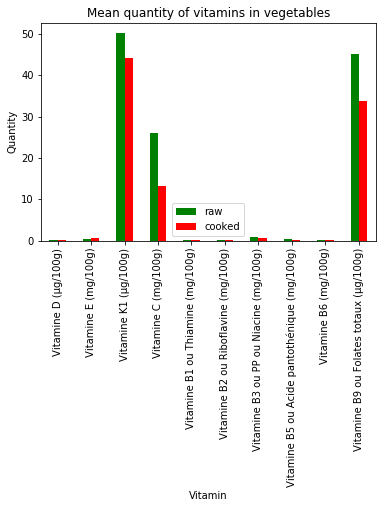

In [88]:
vitamins_grouped_df = pd.DataFrame([vitamins_raw_df.mean().rename('raw'),
                                    vitamins_cooked_df.mean().rename('cooked')])

vitamins_grouped_df = vitamins_grouped_df.transpose()

vitamins_grouped_df.plot(kind='bar', color=['green', 'red'])

plt.title('Mean quantity of vitamins in vegetables')
plt.xlabel('Vitamin')
plt.ylabel('Quantity')

plt.show()

As a reminder, this is simply an example to illustrate this complementary and what we could get from it.

## Conclusion: proposed data story <a class="anchor" id="conclusion"></a> 

After preliminary investigations of the research questions proposed during the first milestone, we have decided to focus our analysis on the fundamental question bio vs. regular products.

We would start with a short introduction about the Open Food Facts dataset. We would give some background about the nutritional scores, and the way they are computed. Since this score computation is not straightforward, we would like to perform the linear regression presented in this notebook (Q1) to provide a more interpretable way to assess the impact of the differents nutriments on the nutritional score.

Then we dive into our main question: the comparison of bio and regular products. Overall the common view is that bio products are healthier than regular ones. Hence we would like to use the chosen dataset to quantitatively validate or refute this fact.

A few points we would like to compare:
* Nutritional scores 
* Additives present in the products
* Distribution of products in the Nova groups
* Composition (ingredients and nutriments) (in progress)
* Optional: Proportion of bio/regular products in USA and France

We still need to decide on the particular visualization we want to provide, but we already have a few interesting results.